In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

# Load dataset
file_path = './data/Tempat-Wisata-Toba-Preprocessing.csv'
df = pd.read_csv(file_path)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\user\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Data Preparation

In [20]:
# Hapus data kosong pada kolom penting
df.dropna(subset=['ReviewerId', 'PlaceID', 'Rating'], inplace=True)

In [3]:
df['ReviewerId'] = df['ReviewerId'].astype(str)
df['PlaceID'] = df['PlaceID'].astype(str)

# Split data menjadi train, validation, dan test (70:15:15)
train_data, test_data = train_test_split(df, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1765, random_state=42)

In [4]:
# Pastikan kombinasi 'ReviewerId' dan 'PlaceID' unik
train_data = train_data.groupby(['ReviewerId', 'PlaceID'], as_index=False)['Rating'].mean()

# Membentuk matriks user-item
user_item_matrix = train_data.pivot(index='ReviewerId', columns='PlaceID', values='Rating')

# Hitung sparsity
num_total_entries = user_item_matrix.size
num_nonzero_entries = user_item_matrix.count().sum()
sparsity = 1 - (num_nonzero_entries / num_total_entries)
print(f"Initial Data Sparsity: {sparsity:.2%}")

Initial Data Sparsity: 97.74%


In [5]:
# 4. Tingkatkan Densitas Data
# Rata-rata rating per user dan item
user_mean_ratings = user_item_matrix.mean(axis=1)
item_mean_ratings = user_item_matrix.mean(axis=0)

# Tambahkan user-item pair berdasarkan heuristik
def fill_missing_values(user_item_matrix, user_mean_ratings, item_mean_ratings, threshold=0.1):
    filled_matrix = user_item_matrix.copy()
    for user_id in user_item_matrix.index:
        for item_id in user_item_matrix.columns:
            if pd.isna(user_item_matrix.loc[user_id, item_id]):
                if np.random.rand() < threshold:
                    filled_matrix.loc[user_id, item_id] = (
                        user_mean_ratings[user_id] * 0.5 + item_mean_ratings[item_id] * 0.5
                    )
    return filled_matrix

# Mengisi nilai kosong dengan heuristik
filled_user_item_matrix = fill_missing_values(user_item_matrix, user_mean_ratings, item_mean_ratings, threshold=0.1)

# Hitung sparsity setelah pengisian
num_nonzero_entries = filled_user_item_matrix.astype(bool).sum().sum()
sparsity = 1 - (num_nonzero_entries / num_total_entries)
print(f"Data Sparsity After Filling: {sparsity:.2%}")

Data Sparsity After Filling: 0.00%


In [12]:
# Pastikan matriks user-item sudah terisi nilai
user_item_matrix = user_item_matrix.fillna(0)

# Konversi matriks user-item ke numpy array
filled_user_item_matrix_values = user_item_matrix.values

In [13]:
# 5. Model KNN
# Konversi matriks user-item ke numpy array
filled_user_item_matrix_values = filled_user_item_matrix.fillna(0).values

# Melatih model KNN
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(filled_user_item_matrix_values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

# 1. Normalisasi Matriks Rating
filled_user_item_matrix = user_item_matrix.fillna(0)
max_rating = train_data['Rating'].max()
normalized_matrix = filled_user_item_matrix / max_rating  # Normalisasi ke 0-1

# 2. Evaluasi dengan Parameter Tuning
def evaluate_model(test_data, user_item_matrix, model, k=5):
    actual_ratings = []
    predicted_ratings = []
    for _, row in test_data.iterrows():
        user_id = row['ReviewerId']
        place_id = row['PlaceID']
        if user_id in user_item_matrix.index and place_id in user_item_matrix.columns:
            user_vector = user_item_matrix.loc[user_id].values.reshape(1, -1)
            distances, indices = model.kneighbors(user_vector, n_neighbors=k)
            neighbor_ratings = user_item_matrix.iloc[indices.flatten()].mean(axis=0)
            predicted_ratings.append(neighbor_ratings.get(place_id, 0))
            actual_ratings.append(row['Rating'] / max_rating)  # Normalisasi actual
    # Hitung metrik evaluasi
    mse = mean_squared_error(actual_ratings, predicted_ratings)
    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    return mse, mae

# Tuning Parameter
param_grid = {'n_neighbors': [3, 5, 7, 10]}
best_mse, best_mae, best_k = float('inf'), float('inf'), None

for params in ParameterGrid(param_grid):
    k = params['n_neighbors']
    mse, mae = evaluate_model(test_data, normalized_matrix, model_knn, k=k)
    if mse < best_mse:
        best_mse, best_mae, best_k = mse, mae, k
    print(f"k={k}, MSE={mse:.4f}, MAE={mae:.4f}")

print(f"\nBest k={best_k}, Best MSE={best_mse:.4f}, Best MAE={best_mae:.4f}")

k=3, MSE=0.8018, MAE=0.8644
k=5, MSE=0.7998, MAE=0.8640
k=7, MSE=0.7996, MAE=0.8644
k=10, MSE=0.7987, MAE=0.8646

Best k=10, Best MSE=0.7987, Best MAE=0.8646


In [15]:
# 3. Menampilkan Hasil Evaluasi
print(f"RMSE: {best_mse}")
print(f"MAE: {best_mae}")

RMSE: 0.7987410489189414
MAE: 0.864637490608565


In [16]:
from collections import defaultdict
import numpy as np

# Fungsi untuk menghitung Precision, Recall, MAP
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    """
    Compute precision@k, recall@k, and mean average precision (MAP) at k for each user.
    """
    # Map predictions to each user
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        # Sort predictions by estimated rating
        user_ratings.sort(key=lambda x: x[0], reverse=True)  # Sort by est
        user_ratings = user_ratings[:k]

        # Count relevant items
        relevant = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        retrieved = len(user_ratings)

        # Prevent division by zero
        if retrieved > 0:
            precision = relevant / retrieved
        else:
            precision = 0
        
        # Count all relevant items in true ratings
        all_relevant = sum((true_r >= threshold) for (_, true_r) in user_est_true[uid])
        
        if all_relevant > 0:
            recall = relevant / all_relevant
        else:
            recall = 0

        precisions.append(precision)
        recalls.append(recall)

    # Compute mean average precision (MAP)
    map_score = np.mean(precisions) if precisions else 0

    # Average precision and recall over all users
    precision_avg = np.mean(precisions) if precisions else 0
    recall_avg = np.mean(recalls) if recalls else 0

    return precision_avg, recall_avg, map_score

# Fungsi untuk evaluasi model hanya dengan metrik Precision, Recall, MAP
def evaluate_model_with_ranking_metrics(test_data, user_item_matrix, model, k_values=[5, 10]):
    predictions = []  # To store prediction results for Precision/Recall/MAP
    ranking_metrics = {}  # To store ranking metrics for all k values
    
    for _, row in test_data.iterrows():
        user_id = row['ReviewerId']
        place_id = row['PlaceID']
        
        if user_id in user_item_matrix.index and place_id in user_item_matrix.columns:
            user_vector = user_item_matrix.loc[user_id].values.reshape(1, -1)
            distances, indices = model.kneighbors(user_vector, n_neighbors=max(k_values))
            neighbor_ratings = user_item_matrix.iloc[indices.flatten()].mean(axis=0)
            
            predicted_rating = neighbor_ratings.get(place_id, 0)
            actual_rating = row['Rating']
            
            # Menyimpan hasil prediksi untuk menghitung Precision/Recall/MAP
            predictions.append((user_id, place_id, actual_rating, predicted_rating, 0))  # Add 0 as a placeholder for timestamp or other data

    # Menghitung Precision, Recall, MAP untuk setiap nilai k
    for k in k_values:
        precision, recall, map_score = precision_recall_at_k(predictions, k=k)
        ranking_metrics[k] = {'Precision': precision, 'Recall': recall, 'MAP': map_score}
    
    return ranking_metrics

# Contoh pemanggilan fungsi
k_values = [5, 10]  # Evaluate for Precision@5 and Precision@10

# Memanggil fungsi evaluasi dengan model KNN yang telah dilatih
ranking_metrics = evaluate_model_with_ranking_metrics(test_data, user_item_matrix, model_knn, k_values=[5, 10])

# Menampilkan hasil
for k in [5, 10]:
    print(f"Metrics for k={k}:")
    print("  Precision:", ranking_metrics[k]['Precision'])
    print("  Recall:", ranking_metrics[k]['Recall'])
    print("  MAP:", ranking_metrics[k]['MAP'])


Metrics for k=5:
  Precision: 0.8754583134066635
  Recall: 0.8962446767324816
  MAP: 0.8754583134066635
Metrics for k=10:
  Precision: 0.8754583134066635
  Recall: 0.8964610234337638
  MAP: 0.8754583134066635


In [ ]:
# # 3. Evaluasi pada test data
# rmse, mae, precision_avg, recall_avg, map_avg = evaluate_model_with_ranking_metrics(
#     test_data, filled_user_item_matrix, model_knn, k_values=[5, 10]
# )

In [ ]:
# # 4. Menampilkan Hasil Evaluasi
# print(f"RMSE: {best_mse}")
# print(f"MAE: {best_mae}")
# print("Precision@10:", precision_avg)
# print("Recall@10:", recall_avg)
# print("MAP@10:", map_avg)

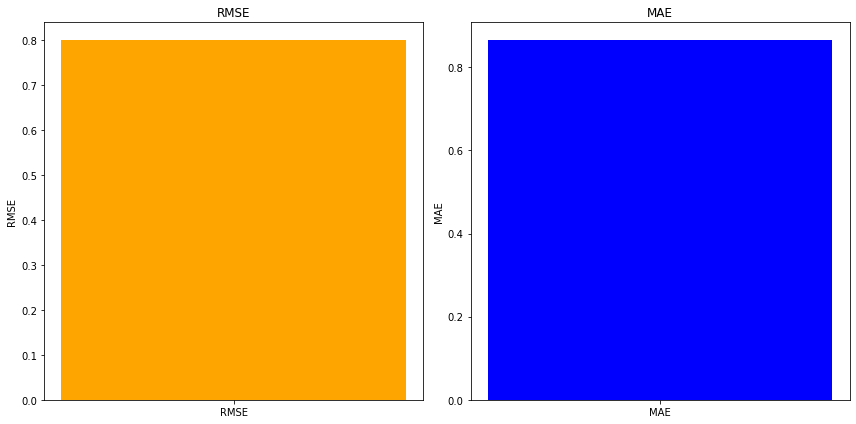

In [17]:
# 5. Menampilkan Grafik untuk Metrik RMSE dan MAE
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# RMSE and MAE plot
ax[0].bar(['RMSE'], [best_mse], color='orange')
ax[0].set_ylabel('RMSE')
ax[0].set_title('RMSE')

ax[1].bar(['MAE'], [best_mae], color='blue')
ax[1].set_ylabel('MAE')
ax[1].set_title('MAE')

plt.tight_layout()
plt.show()

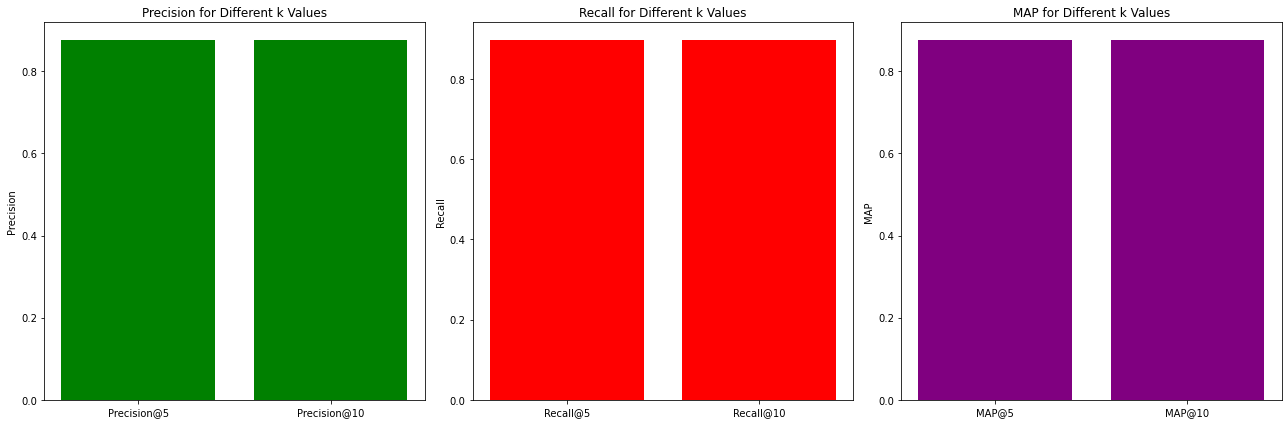

In [18]:
import matplotlib.pyplot as plt

# 6. Menampilkan Grafik untuk Ranking Metrik (Precision, Recall, MAP)
def plot_ranking_metrics(ranking_metrics):
    """
    Plot Precision, Recall, and MAP for different k values.
    """
    k_values = list(ranking_metrics.keys())
    precision_values = [ranking_metrics[k]['Precision'] for k in k_values]
    recall_values = [ranking_metrics[k]['Recall'] for k in k_values]
    map_values = [ranking_metrics[k]['MAP'] for k in k_values]

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Precision
    ax[0].bar([f'Precision@{k}' for k in k_values], precision_values, color='green')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Precision for Different k Values')

    # Recall
    ax[1].bar([f'Recall@{k}' for k in k_values], recall_values, color='red')
    ax[1].set_ylabel('Recall')
    ax[1].set_title('Recall for Different k Values')

    # MAP
    ax[2].bar([f'MAP@{k}' for k in k_values], map_values, color='purple')
    ax[2].set_ylabel('MAP')
    ax[2].set_title('MAP for Different k Values')

    plt.tight_layout()
    plt.show()

# Contoh Pemanggilan
plot_ranking_metrics(ranking_metrics)

In [19]:
# 6. Menampilkan Top 5 Rekomendasi Tempat Wisata Secara Keseluruhan dalam Bentuk Tabel
def get_top_n_overall_recommendations(user_item_matrix, model, n=5):
    """
    Menghasilkan rekomendasi untuk keseluruhan tempat wisata berdasarkan model KNN.
    """
    recommendations = []
    
    # Mencari tetangga pengguna berdasarkan pola rating mereka
    for user_id in user_item_matrix.index:
        user_ratings = user_item_matrix.loc[user_id].values.reshape(1, -1)  # Bentuk data untuk KNN
        
        # Mencari tetangga pengguna yang relevan
        distances, indices = model.kneighbors(user_ratings, n_neighbors=5)
        
        # Menghitung rata-rata rating berdasarkan tetangga pengguna yang relevan
        recommended_places = user_item_matrix.iloc[indices.flatten(), :].mean(axis=0)
        
        # Menyusun rekomendasi berdasarkan rating tertinggi
        for place_id, predicted_rating in recommended_places.items():  # Gunakan .items() untuk Series
            recommendations.append((place_id, predicted_rating))
    
    # Mengurutkan rekomendasi berdasarkan prediksi rating tertinggi
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    
    # Ambil n rekomendasi teratas
    top_n_recommendations = recommendations[:n]
    
    # Membuat DataFrame untuk menampilkan hasil dalam bentuk tabel
    recommendation_df = pd.DataFrame(top_n_recommendations, columns=['PlaceID', 'Predicted Rating'])
    
    # Menambahkan kolom nama tempat berdasarkan PlaceID
    recommendation_df['Nama Tempat Wisata'] = recommendation_df['PlaceID'].apply(
        lambda place_id: df[df['PlaceID'] == place_id]['Nama_tempat_wisata'].values[0])
    
    # Menyusun ulang kolom agar tampil dalam urutan yang diinginkan
    recommendation_df = recommendation_df[['Nama Tempat Wisata', 'Predicted Rating']]
    
    return recommendation_df

# Menampilkan 5 tempat wisata terbaik berdasarkan prediksi rating dalam bentuk tabel
top_n_overall_recommendations = get_top_n_overall_recommendations(filled_user_item_matrix, model_knn, n=5)

# Menampilkan hasil rekomendasi dalam bentuk tabel
print("Top 5 Rekomendasi Tempat Wisata:")
print(top_n_overall_recommendations)

Top 5 Rekomendasi Tempat Wisata:
   Nama Tempat Wisata  Predicted Rating
0  Danau Toba Parapat               5.0
1      Huta Siallagan               5.0
2        Pantai Paris               5.0
3  Danau Toba Parapat               5.0
4    Geosite Sipinsur               5.0
